Load Modules

In [1]:
#Soft max regression classifier
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
import operator
import seaborn as sns

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

Implement function to implement one-hot labeling

In [2]:
def onehotlabels(Y):
    dict_label={}
    labels = list(Y)
    Y_one_hot=[]
    unique_labels=list(set(labels))
    n_values = np.max(unique_labels) + 1
    Y_binary_code=np.eye(n_values, dtype=int)[unique_labels]
    for i in range(len(unique_labels)):
        dict_label[i]=Y_binary_code[i][:]
    
    # now associate dict label with class
    for i in range(Y.shape[0]):
        key=Y[i]
        value=dict_label.get(key) 
        Y_one_hot.append(value)
    return np.asarray(Y_one_hot)

Initialize function to count number of TP, TN, FP, and FN

In [3]:
def eval_bins(label,prediction):
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    for i in range(0,len(label)):
        if prediction[i]==1:
            if prediction[i]==label[i]:
                true_positives+=1
            else:
                false_positives+=1
        else:
            if prediction[i]==label[i]:
                true_negatives+=1
            else:
                false_negatives+=1
    return  true_positives,true_negatives,false_positives,false_negatives

This definition to find accuracy

In [4]:
def find_accuracy(label,prediction):
    #label =list vector of true labels
    #prediction=list vector of predicted labels
    tp,tn,fp,fn=eval_bins(label,prediction)
    #ratio of correctly predicted observations to total observations
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    return accuracy

This definition calculates the softmax scores

In [5]:
def softmax(scores):
    pred_array = np.exp(scores)
    # Now normalize such that total probability for each sample sums to 1
    pred_array/pred_array.sum(axis=1)[:,None]
    return pred_array

Implement function to calculate cross-entropy loss

In [6]:
def cross_entropy_loss(Y_one_hot,Y_proba):
    loss_sum = 0
    for i in range(Y_one_hot.shape[1]): # Go through each class
        loss_sum += sum(Y_one_hot[:,i]*np.log(Y_proba[:,i]))
    return -loss_sum.mean()

Implement function to calculate cross-entropy loss with L1 Regularization

In [7]:
def cross_entropy_loss_l1(Y_true, Y_pred,lamb,theta):
    # lamb is the regularization parameter
    # theta contains the weights
    
    # Note bias term excluded for regularized addition term
    theta_sum = sum([theta[index,:] for index in range(1,theta.shape[0])]) # Create column Vector
    theta_sum = sum(theta_sum) # Sum into single number
    cost = cross_entropy_loss(Y_true,Y_pred) + lamb/2*theta_sum
    
    return cost

Implement function to calculate cross-entropy loss with L2 Regularization

In [8]:
def cross_entropy_loss_l2(Y_true, Y_pred,lamb,theta):
    # lamb is the regularization parameter
    # theta contains the weights
    
    # Note bias term excluded for regularized addition term
    theta_sum_sqrd = sum([theta[index]**2 for index in range(1,theta.shape[0])])
    theta_sum_sqrd = sum(theta_sum_sqrd)
    cost = cross_entropy_loss(Y_true,Y_pred) + lamb/2*theta_sum_sqrd
    
    return cost

Creates Softmax Logistic Regression Class

In [9]:
class Softmax_Regression(): 
    def __init__(self):
        pass
    
    # This definition runs batch gradient descent
    def run_batch_gradient_descent(self,X,Y,num_classes,m,n):
        num_iterations=0
        Y_one_hot=onehotlabels(Y.flatten())
        while num_iterations<=epochs:
            num_iterations+=1
            Y_pred_proba=self.pred_prob(X)
            diff_piece=Y_pred_proba-Y_one_hot # Column vector
            inner_product = np.matmul(X.T,diff_piece)
            inner_product=np.asarray(inner_product)#should have dimensions of self.theta
            gradient=(self.learning_rate/m)*inner_product#should have dimensions of self.theta#check
            if 'None' in self.regularizer:
                #update rule
                self.theta=self.theta-gradient
                #using this new weight evaluate new prediction
                Y_pred_proba=self.pred_prob(X)
                #evaluate cross entropy loss
                error=cross_entropy_loss(Y_one_hot,Y_pred_proba)
            if ('l1' in regularizer):
                self.theta=self.theta-gradient-(self.learning_rate*self.lambd/m)*np.sign(self.theta)
                Y_pred_proba=self.pred_prob(X)
                error=cross_entropy_loss_l1(Y_one_hot,Y_pred_proba,self.lambd,self.theta)
            if ('l2' in regularizer):
                self.theta=self.theta-gradient-(self.learning_rate*self.lambd/m)*np.sign(self.theta)
                Y_pred_proba=self.pred_prob(X)
                error=cross_entropy_loss_l2(Y_one_hot,Y_pred_proba,self.lambd,self.theta)
                
                # Each time check to see if error not decreasing significantly before looping back through
            if ((num_iterations > 1) & ~('None' is self.tol)): # Can only check if not the first pass
                if abs(error-previous_error) < self.tol:
                    break # Break out if we are not improving our error significantly
            previous_error = error    
    
    # This definition runs stochastic gradient descent
    def run_stochastic_gradient_descent(self,X,Y,num_classes,m,n):
        num_iterations=0
        Y_one_hot=onehotlabels(Y.flatten())
        while num_iterations<=epochs:
            
            random_index=np.random.randint(0,m)
            X_i = X[random_index,:].reshape(1,X.shape[1])
            Y_i = Y_one_hot[random_index,:]
    
            num_iterations+=1
            Y_pred_proba=self.pred_prob(X_i)
            diff_piece=Y_pred_proba-Y_i # Column vector
            
            inner_product = np.matmul(X_i.T,diff_piece)
            inner_product=np.asarray(inner_product)#should have dimensions of self.theta
            gradient=(self.learning_rate)*inner_product#should have dimensions of self.theta#check
            if 'None' in self.regularizer:
                #update rule
                self.theta=self.theta-gradient
                #using this new weight evaluate new prediction
                Y_pred_proba=self.pred_prob(X)
                #evaluate cross entropy loss
                error=cross_entropy_loss(Y_one_hot,Y_pred_proba)
            if ('l1' in regularizer):
                self.theta=self.theta-gradient-(self.learning_rate*self.lambd/m)*np.sign(self.theta)
                Y_pred_proba=self.pred_prob(X)
                error=cross_entropy_loss_l1(Y_one_hot,Y_pred_proba,self.lambd,self.theta)
            if ('l2' in regularizer):
                self.theta=self.theta-gradient-(self.learning_rate*self.lambd/m)*np.sign(self.theta)
                Y_pred_proba=self.pred_prob(X)
                error=cross_entropy_loss_l2(Y_one_hot,Y_pred_proba,self.lambd,self.theta)
                
                # Each time check to see if error not decreasing significantly before looping back through
            if ((num_iterations > 1) & ~('None' is self.tol)): # Can only check if not the first pass
                if abs(error-previous_error) < self.tol:
                    break # Break out if we are not improving our error significantly
            previous_error = error   
        
    # This definition fits the data using batch gradient descent
    def fit_batch(self, X, Y, epochs=1000,tol='None',lambd=0.0,learning_rate=0.01,regularizer='None',early_stopping=False,validation_fraction=0.1,**kwargs):
        # the “fit” method should use a weight vector “theta_hat” that contains the
        # parameters for the model (one parameter for each feature and one for bias). The
        # “theta_hat” should be a D column vector.
        # Finally, it should update the model parameter “theta” to be used in “predict”
        # method as follows.
        # self.theta = theta_hat
        
        m = X.shape[0] # Number of elements in X
        n = X.shape[1] # Number of columns in X
        num_unique_classes=np.unique(Y).shape[0]
        # Initialize theta as all zeros with correct dimensions
        self.theta = np.zeros((n, num_unique_classes))
        self.epochs=epochs
        self.lambd=lambd
        self.tol=tol
        self.learning_rate=learning_rate
        self.regularizer=regularizer
        self.weights_class=[]
        #run_stoc_gradient_descent(X,Y,num_unique_classes,m,n)#incorporate this
        if early_stopping:
            self.n_iter_step=100
            true_epochs=self.epochs
            self.epochs=self.n_iter_step
            tot_steps=int(true_epochs/self.n_iter_step)
            cut=int(len(X)*validation_fraction)
            x_valid, x_subtrain = X[:cut], X[cut:]
            y_valid, y_subtrain = Y[:cut], Y[cut:]
            rows=x_subtrain.shape[0]
            columns=x_subtrain.shape[1]
            y_subtrain_one_hot=onehotlabels(y_subtrain.flatten())
            y_valid_one_hot=onehotlabels(y_valid.flatten())
            iter_step=[]
            error_train=[]
            error_valid=[]
            self.weights_class=[]
            for i in range(tot_steps):
                self.run_batch_gradient_descent(x_subtrain,y_subtrain,num_unique_classes,rows,columns)#run for the first hundred epochs
                y_predictions_train=self.pred_prob(x_subtrain)
                y_predictions_test=self.pred_prob(x_valid)
                error_train.append(cross_entropy_loss(y_subtrain_one_hot,y_predictions_train))
                error_valid.append(cross_entropy_loss(y_valid_one_hot, y_predictions_test))
                iter_step.append((i+1)*self.n_iter_step)
                if i>1:
                    if abs(error_valid[i-1])<abs(error_valid[i]):
                        print('Hit the condition for early stopping')
                        self.theta=prev_weights
                        break
                prev_weights = self.theta
            self.epochs = true_epochs # Put back true epochs after loop is complete
            # Below plots the “learning curve for train and test set”
            plt.figure(figsize=(10, 6))   
            plt.plot(iter_step, error_train, "ro-", alpha=1.0, linewidth=1.0, label="Train Cross-Entropy")
            plt.plot(iter_step, error_valid, "bo-", alpha=1.0, linewidth=1.0, label="Validation Cross-Entropy")    
            plt.legend(loc="best", fontsize=14) 
            plt.xlabel("Iteration step")
            plt.ylabel("Cross-Entropy")
            plt.title("Early stopping curve")
            plt.show()
        else:
            self.run_batch_gradient_descent(X,Y,num_unique_classes,m,n)
    
    # This definition fits the data using stochastic gradient descent
    def fit_stochastic(self, X, Y, epochs=1000,tol='None',lambd=0.0,learning_rate=0.01,regularizer='None',early_stopping=False,validation_fraction=0.1,**kwargs):
        # the “fit” method should use a weight vector “theta_hat” that contains the
        # parameters for the model (one parameter for each feature and one for bias). The
        # “theta_hat” should be a D column vector.
        # Finally, it should update the model parameter “theta” to be used in “predict”
        # method as follows.
        # self.theta = theta_hat
        
        m = X.shape[0] # Number of elements in X
        n = X.shape[1] # Number of columns in X
        num_unique_classes=np.unique(Y).shape[0]
        # Initialize theta as all zeros with correct dimensions
        self.theta = np.zeros((n, num_unique_classes))
        self.epochs=epochs
        self.lambd=lambd
        self.tol=tol
        self.learning_rate=learning_rate
        self.regularizer=regularizer
        self.weights_class=[]
        #run_stoc_gradient_descent(X,Y,num_unique_classes,m,n)#incorporate this
        if early_stopping:
            self.n_iter_step=100
            true_epochs=self.epochs
            self.epochs=self.n_iter_step
            tot_steps=int(true_epochs/self.n_iter_step)
            cut=int(len(X)*validation_fraction)
            x_valid, x_subtrain = X[:cut], X[cut:]
            y_valid, y_subtrain = Y[:cut], Y[cut:]
            rows=x_subtrain.shape[0]
            columns=x_subtrain.shape[1]
            y_subtrain_one_hot=onehotlabels(y_subtrain.flatten())
            y_valid_one_hot=onehotlabels(y_valid.flatten())
            iter_step=[]
            error_train=[]
            error_valid=[]
            self.weights_class=[]
            for i in range(tot_steps):
                self.run_stochastic_gradient_descent(x_subtrain,y_subtrain,num_unique_classes,rows,columns)#run for the first hundred epochs
                y_predictions_train=self.pred_prob(x_subtrain)
                y_predictions_test=self.pred_prob(x_valid)
                error_train.append(cross_entropy_loss(y_subtrain_one_hot,y_predictions_train))
                error_valid.append(cross_entropy_loss(y_valid_one_hot, y_predictions_test))
                iter_step.append((i+1)*self.n_iter_step)
                if i>1:
                    if abs(error_valid[i-1])<abs(error_valid[i]):
                        print('Hit the condition for early stopping')
                        self.theta=prev_weights
                        break
                prev_weights = self.theta
            self.epochs = true_epochs # Put back true epochs after loop is complete
            # Below plots the “learning curve for train and test set”
            plt.figure(figsize=(10, 6))   
            plt.plot(iter_step, error_train, "ro-", alpha=1.0, linewidth=1.0, label="Train Cross-Entropy")
            plt.plot(iter_step, error_valid, "bo-", alpha=1.0, linewidth=1.0, label="Validation Cross-Entropy")    
            plt.legend(loc="best", fontsize=14) 
            plt.xlabel("Iteration step")
            plt.ylabel("Cross-Entropy")
            plt.title("Early stopping curve")
            plt.show()
        else:
            self.run_stochastic_gradient_descent(X,Y,num_unique_classes,m,n)
    
    # This calculates the probabilities for each class
    def pred_prob(self, X):
        pred_array=softmax(np.matmul(X,self.theta))
        pred_array_normalized=pred_array/pred_array.sum(axis=1)[:,None]
        return pred_array_normalized
   
    # This calculates the most likely label for each instance
    def predict(self,X):
        #this predicts class of the test set
        score_array = self.pred_prob(X)
        index_max=score_array.argmax(axis=1)
        classes=[item[1] for item in self.theta]
        y_pred_instance=np.asarray([classes[i] for i in index_max])
        return index_max
 

Load the iris dataset into memory

In [10]:
# 
from sklearn import datasets
iris = datasets.load_iris()
# Data Matrix
X = iris["data"]
print(X.shape)

# Target Vector
y = iris["target"] 
print(y.shape)

(150, 4)
(150,)


Apply one hot encoding to the labels

In [11]:
Y_one_hot=onehotlabels(y)

Convert target into a dataframe

In [12]:
feature_names=list(iris.feature_names)
feature_names.append('labels')

y=y.reshape(-1,1)

full_matrix=np.hstack((X,y))
df_iris=pd.DataFrame(data=full_matrix,columns=feature_names)

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),labels
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Count up number of times each class occurs and display as a histogram

2.0    50
1.0    50
0.0    50
Name: labels, dtype: int64


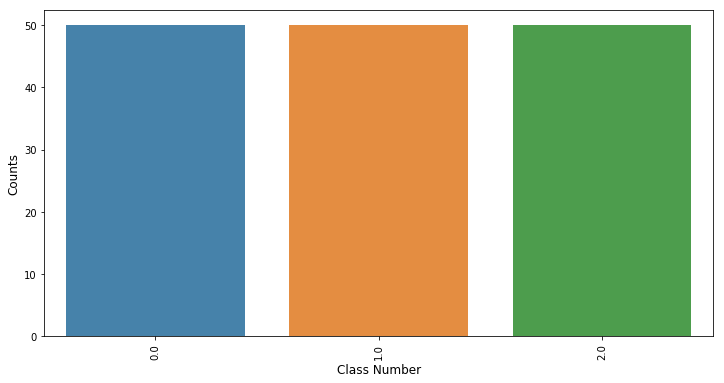

In [13]:
label_counts = df_iris['labels'].value_counts()

print(label_counts)
# Plot the frequency found above in a histogram to visualize number of emails corresponding to categories
# Note the categories chosen have been shuffled, so we do not know which number corresponds to which category

plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Class Number', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

Calculate percentile of target columns along with other statistics

In [14]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),labels
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


Shuffle the order of the rows

In [15]:
df_iris = df_iris.sample(frac=1)

Initialize functions to display correlation and covariance with pairwise plots for features

In [16]:
from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .6), xycoords=ax.transAxes, size = 24)
# This is a definition to create the pairwise seaborn plots
def create_pairwise_plots(df):
    cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)
    sns.set_context(font_scale=2)
    g = sns.PairGrid(df) # Set up pair grid
    g.map_upper(plt.scatter, s=10, color = 'red') # Set up scatter plot on the upper triangle
    g.map_diag(sns.distplot, kde=False, color = 'red') # Set up distribution on the diagonal
    g.map_lower(sns.kdeplot, cmap = cmap) # Include density Plot on the lower triangle
    g.map_lower(corrfunc); # Add correlation coefficients to density plots on the lower triangle  

Create pairwise plots

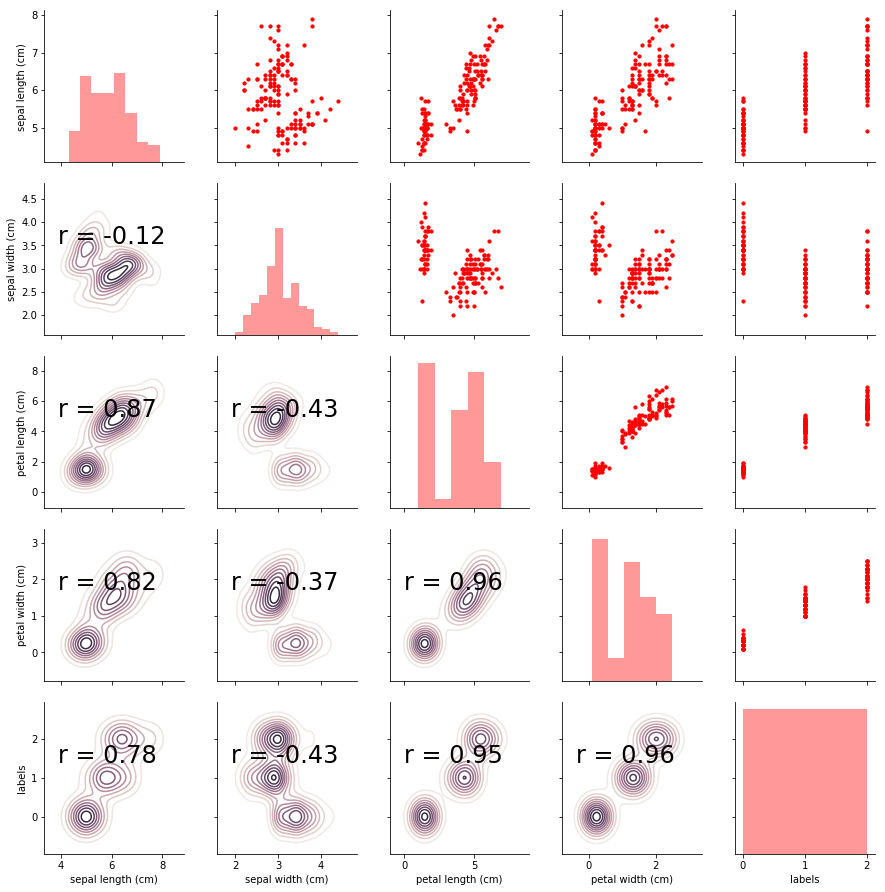

In [17]:
create_pairwise_plots(df_iris)    

Drop the redundant feature

In [18]:
df_iris = df_iris.drop(columns=['petal length (cm)'])

df_iris.head()

,sepal length (cm),sepal width (cm),petal width (cm),labels
52,6.9,3.1,1.5,1.0
23,5.1,3.3,0.5,0.0
129,7.2,3.0,1.6,2.0
120,6.9,3.2,2.3,2.0
62,6.0,2.2,1.0,1.0


Scale the data

In [19]:
from sklearn.preprocessing import StandardScaler
# Features are separated in to X
X = df_iris.drop(columns='labels') # Remove quality
X = X.values

# Target Vector (labels) is set as Y
Y = df_iris["labels"]
Y = Y.values.astype(np.int).reshape((X.shape[0], 1))

# This box scales the feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Create definition to add intercept

In [20]:
def add_intercept(X):
        intercept=np.ones((X.shape[0],1))
        return np.concatenate((intercept,X),axis=1)

This box creates definition to partition data into training and testing sets

In [21]:
def partion(X,Y,t,random_state):
    np.random.seed(seed=random_state)
    num_rows = X.shape[0]
    test_size = int(t * num_rows)
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    test_rows = row_vec[0 : test_size]
    
    train_rows = row_vec[test_size+1:len(row_vec)-1]
    
    # Now define x and y for training and testing
    X_test = X[test_rows,:]
    X_train = X[train_rows,:]
    Y_test = Y[test_rows]
    Y_train = Y[train_rows]
    return X_test,X_train,Y_test,Y_train

Partition the data into testing and training sets

In [22]:
random_state = 24 # Used for seeding random generator in function
t = 0.20 # Fraction of data to keep in testing set
X_test,X_train,Y_test,Y_train = partion(X,Y,t,random_state)

print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

# Add intercept to both features
X_test=add_intercept(X_test)
X_train=add_intercept(X_train)

Y_test=np.reshape(Y_test,[-1])

(30, 3)
(118, 3)
(30, 1)
(118, 1)


Used by Kfold function to split up data sent in into correct pieces

In [23]:
def split_data_folds(folds,data,labels,random_state):
    np.random.seed(seed=random_state)
    num_rows=data.shape[0]
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    data=data[row_vec,:]
    labels=labels[row_vec]
    fold_size=int(data.shape[0]/folds) # Number of rows in each set
    fold_list=[]
    for i in range(folds):
        data_fold=data[i*fold_size:(i+1)*fold_size,:]
        labels_fold=labels[i*fold_size:(i+1)*fold_size]
        fold_list.append((data_fold,labels_fold))
    return fold_list 

Function which performs k-fold cross-validation

In [24]:
def kFold(folds, data, labels, model, model_args, error_function):
    random_state=42
    dataset_split=split_data_folds(folds,data,labels,random_state)
    kwargs={}
    error_per_fold=[]
    preds_per_fold=[]
    dict_per_fold={}
    keys=[]
    
    for i in range(folds):
        X_split_test=dataset_split[i][0]
        Y_split_test=dataset_split[i][-1]
        X_split_train=dataset_split[~i][0]
        Y_split_train=dataset_split[~i][-1]
        
        fit_function=model[0]
        predict_function=model[1]
        
        fit_function(X_split_train,Y_split_train, *model_args,**kwargs)
        
        naive_train_predictions=predict_function(X_split_train)# this is a list of lists
        naive_test_predictions=predict_function(X_split_test)# this is a list of lists
        
        test_preds = naive_test_predictions
        train_preds = naive_train_predictions
        
        cost_fun_test=error_function(Y_split_test.flatten(),test_preds.flatten())
        cost_fun_train=error_function(Y_split_train,train_preds)
        error_per_fold.append((cost_fun_train,cost_fun_test))
        preds_per_fold.append((test_preds,Y_split_test))
        keys.append(i)
    
    values=[[p1, p2] for idx1, p1 in enumerate(preds_per_fold) for idx2, p2 in enumerate(error_per_fold) if idx1==idx2]
    dict_per_fold=dict(zip(keys, values))
    return dict_per_fold

In the below block we perform K-Fold Cross-Fold Validation using Batch Gradient Descent to find the optimal hyperparameters.<br>

In [25]:
# In this block we perform k-fold cross-validation

folds = 4 # Number of folds to use for cross validation
lambd = [1.0, 0.1, 0.01, 0.001, 0.0001,0.0]
tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
learning_rate = [0.1, 0.01, 0.001]
# regularizer = ['l1', 'l2']
regularizer = ['l1','l2']

epochs = 100000 # We choose to use this value
error_function = find_accuracy# Error function to use for evaluation
early_stopping=False
validation_fraction=0.2

model_performance_list = np.empty([1,6]) # Initialize as empty
num_comb = len(lambd)*len(learning_rate)*len(regularizer)*len(tol)
count = 1
error_fold_train = []
error_fold_test = []
for lambd_curr in lambd:
    for learning_rate_curr in learning_rate:
        for regularizer_curr in regularizer:
            for tol_curr in tol:
                print('Looking at combination %i of %i' %(count,num_comb))
                count+=1
                model_name = Softmax_Regression()
                model = [model_name.fit_batch,model_name.predict]
                model_args = [epochs,tol_curr,lambd_curr,learning_rate_curr,regularizer_curr,early_stopping,validation_fraction]

                dict_temp = kFold(folds, X, Y, model, model_args, error_function)
                error_fold_train = []
                error_fold_test = []

                for kk,jj in dict_temp.items():
                    error_fold_train.append(jj[-1][0]) # Holds error for training sets
                    error_fold_test.append(jj[-1][1]) # Holds error for testing sets
                eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
                std_error_train = np.std(np.asarray(error_fold_train))
                eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
                std_error_test = np.std(np.asarray(error_fold_test))
                # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
                model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,tol_curr,eavg_test,eavg_train]))

# Remove first row from model_performance_list as it contained the random values used to initialize it
model_performance_list=np.delete(model_performance_list, [0], axis=0)

# Save full output of s-fold cross-validation to disk for use in report
df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'Tolerance', 'Accuracy-From Testing Sets','Accuracy-From Training Sets']) # Convert to pandas dataframe

print('\n')
print(df_s_fold)

# Replace any inf or nan with np.nan for dropping in next step
df_s_fold=df_s_fold.replace('inf', np.nan)
df_s_fold=df_s_fold.replace('nan', np.nan)
# Now drop all rows containing NaN
df_s_fold=df_s_fold.dropna()
print('\n')
print('Below are the values corresponding to the largest Accuracy from the testing sets during cross-validation')
# Now find row index corresponding to lowest MSE from testing sets
print(df_s_fold[df_s_fold['Accuracy-From Testing Sets']==df_s_fold['Accuracy-From Testing Sets'].max()])

Looking at combination 1 of 180
Looking at combination 2 of 180
Looking at combination 3 of 180
Looking at combination 4 of 180
Looking at combination 5 of 180
Looking at combination 6 of 180
Looking at combination 7 of 180
Looking at combination 8 of 180
Looking at combination 9 of 180
Looking at combination 10 of 180
Looking at combination 11 of 180
Looking at combination 12 of 180
Looking at combination 13 of 180
Looking at combination 14 of 180
Looking at combination 15 of 180
Looking at combination 16 of 180
Looking at combination 17 of 180
Looking at combination 18 of 180
Looking at combination 19 of 180
Looking at combination 20 of 180
Looking at combination 21 of 180
Looking at combination 22 of 180
Looking at combination 23 of 180
Looking at combination 24 of 180
Looking at combination 25 of 180
Looking at combination 26 of 180
Looking at combination 27 of 180
Looking at combination 28 of 180
Looking at combination 29 of 180
Looking at combination 30 of 180
Looking at combinat

From the above results it is clear that we have many options for this Logistic Regression model using Batch Gradient Descent.<br>
We will choose to utilize l1 regularization with a learning rate of 0.01, a regularization parameter of 1.0, and a tolerance of 0.001.

Helper function for confusion_matrix which creates an easy to read confusion matrix

In [26]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Calculates and plots a confusion matrix for provided predictions

In [27]:
def confusion_matrix(Y,Y_hat):
    # calculates and plots confusion matrix
    y_actu = pd.Series(Y, name='Actual')
    y_pred = pd.Series(Y_hat, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    plot_confusion_matrix(df_confusion)
    return df_confusion

Counts up number of TP, TN, FP, and FN

In [28]:
def eval_bins(label,prediction):
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    for i in range(0,len(label)):
        if prediction[i]==1:
            if prediction[i]==label[i]:
                true_positives+=1
            else:
                false_positives+=1
        else:
            if prediction[i]==label[i]:
                true_negatives+=1
            else:
                false_negatives+=1
    return  true_positives,true_negatives,false_positives,false_negatives

Below are thus the parameters we will use for the test set

In [29]:
kwargs={}
epochs = 100000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
lambd = 1.0 # Regularizer Parameter
learning_rate = 0.01
regularizer = 'l1'
early_stop_cond=False

Now fit the model

In [30]:
log_reg_model=Softmax_Regression()
log_reg_model.fit_batch(X_train,Y_train,epochs,tol,lambd,learning_rate,regularizer,early_stopping=early_stop_cond,validation_fraction=0.1,**kwargs)

Now make predictions on the test set

In [31]:
y_test_pred=log_reg_model.predict(X_test)

Evaluate these predictions

The accuracy of the prediction on the test set is 0.933333
The corresponding confusion matrix is below:


Predicted,0,1,2
Actual,,,
0,12,0,0
1,0,7,0
2,0,2,9


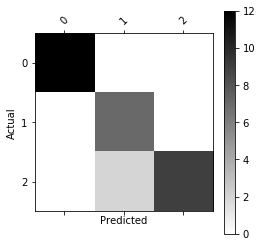

In [32]:
accuracy=find_accuracy(y_test_pred,Y_test)

print('The accuracy of the prediction on the test set is %f' %accuracy)
print('The corresponding confusion matrix is below:')

confusion_matrix(Y_test,y_test_pred)

Now we implement early stopping using gradient descent.<br>
We will run for the same conditions as above, and report the results exactly the same.<br>
We thus reset early_stop_cond to True.

In [33]:
early_stop_cond=True

Fit the model

Hit the condition for early stopping


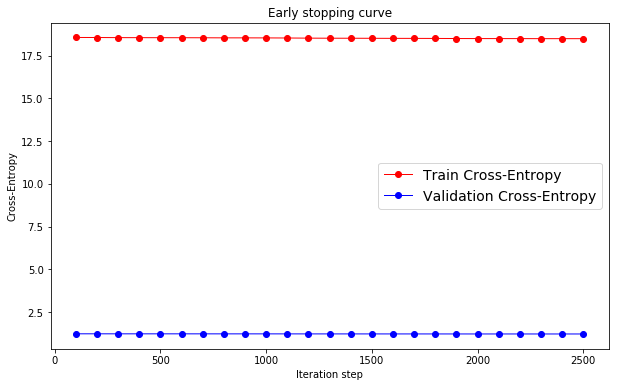

In [34]:
log_reg_model=Softmax_Regression()
log_reg_model.fit_batch(X_train,Y_train,epochs,tol,lambd,learning_rate,regularizer,early_stopping=early_stop_cond,validation_fraction=0.1,**kwargs)

Make predictions on the test set

In [35]:
y_test_pred=log_reg_model.predict(X_test)

Evaluate these predictions

The accuracy of the prediction on the test set is 0.933333
The corresponding confusion matrix is below:


Predicted,0,1,2
Actual,,,
0,12,0,0
1,0,7,0
2,0,2,9


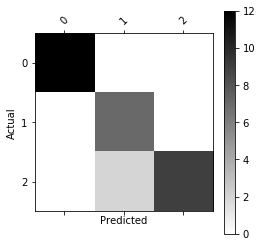

In [36]:
accuracy=find_accuracy(y_test_pred,Y_test)

print('The accuracy of the prediction on the test set is %f' %accuracy)
print('The corresponding confusion matrix is below:')

confusion_matrix(Y_test,y_test_pred)

We now run K-Fold Cross-Validation over Logistic Regression Using Stochastic Gradient Descent

In [37]:
folds = 4 # Number of folds to use for cross validation
lambd = [1.0, 0.1, 0.01, 0.001, 0.0001,0.0]
tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
learning_rate = [0.1, 0.01, 0.001]
# regularizer = ['l1', 'l2']
regularizer = ['l1','l2']

epochs = 1000000 # We choose to use this value
error_function = find_accuracy# Error function to use for evaluation
early_stopping=False
validation_fraction=0.2

model_performance_list = np.empty([1,6]) # Initialize as empty
num_comb = len(lambd)*len(learning_rate)*len(regularizer)*len(tol)
count = 1
error_fold_train = []
error_fold_test = []
for lambd_curr in lambd:
    for learning_rate_curr in learning_rate:
        for regularizer_curr in regularizer:
            for tol_curr in tol:
                print('Looking at combination %i of %i' %(count,num_comb))
                count+=1
                model_name = Softmax_Regression()
                model = [model_name.fit_stochastic,model_name.predict]
                model_args = [epochs,tol_curr,lambd_curr,learning_rate_curr,regularizer_curr,early_stopping,validation_fraction]

                dict_temp = kFold(folds, X, Y, model, model_args, error_function)
                error_fold_train = []
                error_fold_test = []

                for kk,jj in dict_temp.items():
                    error_fold_train.append(jj[-1][0]) # Holds error for training sets
                    error_fold_test.append(jj[-1][1]) # Holds error for testing sets
                eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
                std_error_train = np.std(np.asarray(error_fold_train))
                eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
                std_error_test = np.std(np.asarray(error_fold_test))
                # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
                model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,tol_curr,eavg_test,eavg_train]))
#                 break
#             break
#         break
#     break
# Remove first row from model_performance_list as it contained the random values used to initialize it
model_performance_list=np.delete(model_performance_list, [0], axis=0)

# Save full output of s-fold cross-validation to disk for use in report
df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'Tolerance', 'Accuracy-From Testing Sets','Accuracy-From Training Sets']) # Convert to pandas dataframe
# df_s_fold.tos_csv(reposLink + '/' 'df_s_fold-batch_grad.csv')

print('\n')
print(df_s_fold)

# Replace any inf or nan with np.nan for dropping in next step
df_s_fold=df_s_fold.replace('inf', np.nan)
df_s_fold=df_s_fold.replace('nan', np.nan)
# Now drop all rows containing NaN
df_s_fold=df_s_fold.dropna()
print('\n')
print('Below are the values corresponding to the largest Accuracy from the testing sets during cross-validation')
# Now find row index corresponding to lowest MSE from testing sets
print(df_s_fold[df_s_fold['Accuracy-From Testing Sets']==df_s_fold['Accuracy-From Testing Sets'].max()])

Looking at combination 1 of 180
Looking at combination 2 of 180
Looking at combination 3 of 180
Looking at combination 4 of 180
Looking at combination 5 of 180
Looking at combination 6 of 180
Looking at combination 7 of 180
Looking at combination 8 of 180
Looking at combination 9 of 180
Looking at combination 10 of 180
Looking at combination 11 of 180
Looking at combination 12 of 180
Looking at combination 13 of 180
Looking at combination 14 of 180
Looking at combination 15 of 180
Looking at combination 16 of 180
Looking at combination 17 of 180
Looking at combination 18 of 180
Looking at combination 19 of 180
Looking at combination 20 of 180
Looking at combination 21 of 180
Looking at combination 22 of 180
Looking at combination 23 of 180
Looking at combination 24 of 180
Looking at combination 25 of 180
Looking at combination 26 of 180
Looking at combination 27 of 180
Looking at combination 28 of 180
Looking at combination 29 of 180
Looking at combination 30 of 180
Looking at combinat

From the above results it is clear that we have many options for this Logistic Regression model using Stochastic Gradient Descent.<br>
We will choose to utilize l1 regularization with a learning rate of 0.1, a regularization parameter of 0.1, and a tolerance of 0.0001.

Below are thus the parameters we will use for the test set

In [38]:
kwargs={}
epochs = 1000000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
lambd = 0.1 # Regularizer Parameter
learning_rate = 0.1
regularizer = 'l1'
early_stop_cond=False

Now fit the model

In [39]:
log_reg_model=Softmax_Regression()
log_reg_model.fit_stochastic(X_train,Y_train,epochs,tol,lambd,learning_rate,regularizer,early_stopping=early_stop_cond,validation_fraction=0.1,**kwargs)

Now make predictions on the test set

In [40]:
y_test_pred=log_reg_model.predict(X_test)

Evaluate these predictions

The accuracy of the prediction on the test set is 0.933333
The corresponding confusion matrix is below:


Predicted,0,1,2
Actual,,,
0,12,0,0
1,0,7,0
2,0,2,9


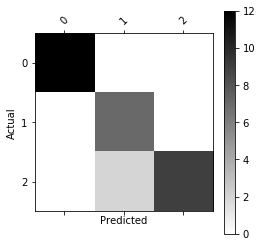

In [41]:
accuracy=find_accuracy(y_test_pred,Y_test)

print('The accuracy of the prediction on the test set is %f' %accuracy)
print('The corresponding confusion matrix is below:')

confusion_matrix(Y_test,y_test_pred)

This makes it appear that Stochastic Gradient Descent does not work as well as Batch Gradient Descent.<br>
Perhaps this could be overcome by using k-fold validation with a greater set of values, but I have not been able to find a more effective combination.<br>
The below results for early stopping make it appear likely that the above problems may actually be due to overfitting.

Now we implement early stopping using stochastic descent.<br>
We will run for the same conditions as above, and report the results exactly the same.<br>
We thus reset early_stop_cond to True.

In [42]:
early_stop_cond=True

Now fit the model

Hit the condition for early stopping


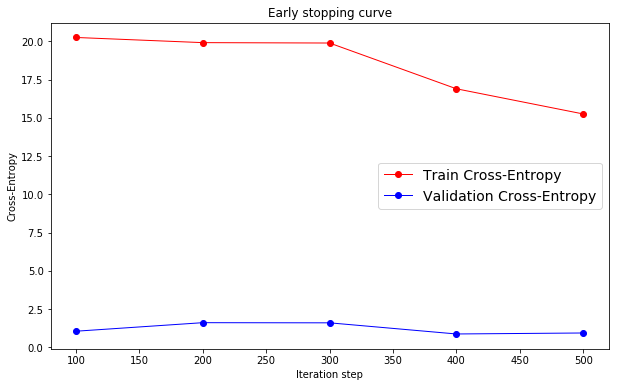

In [43]:
log_reg_model=Softmax_Regression()
log_reg_model.fit_stochastic(X_train,Y_train,epochs,tol,lambd,learning_rate,regularizer,early_stopping=early_stop_cond,validation_fraction=0.1,**kwargs)

Now make predictions on the test set

In [44]:
y_test_pred=log_reg_model.predict(X_test)

Evaluate these predictions

The accuracy of the prediction on the test set is 0.933333
The corresponding confusion matrix is below:


Predicted,0,1,2
Actual,,,
0,12,0,0
1,0,7,0
2,0,2,9


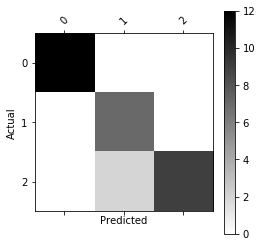

In [45]:
accuracy=find_accuracy(y_test_pred,Y_test)

print('The accuracy of the prediction on the test set is %f' %accuracy)
print('The corresponding confusion matrix is below:')

confusion_matrix(Y_test,y_test_pred)

It appears that early stopping really make a small improvement with Stochastic Gradient Descent.<br>
I would advise using it with this dataset.